In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
np.random.seed(42)
torch.manual_seed(42)
global_dtype = torch.float64
device ='cpu'

### 1. Introduction

---

In this notebook we explore an alternative route for solving the regression problem based on convex optimization in a reproducing kernel hilbert space . We take the same toy example from the GP example in notebook 1.

*As always when reading this notebook it is recommended to collapse all code cells and explore as needed.*

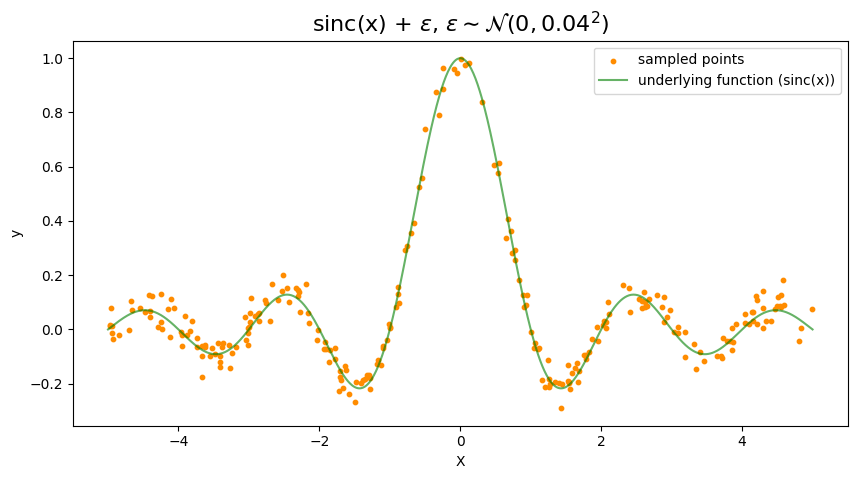

In [15]:
def underlying_function(X):
    base_function = torch.sinc(X)
    noise_std = 0.04
    noise = noise_std * torch.randn_like(X)
    return base_function + noise

n_samples = 250

train_data = torch.sort(10 * torch.rand(n_samples, 1) - 5)[0]
train_labels = underlying_function(train_data)

test_data = torch.linspace(-5, 5, 1000).unsqueeze(1)
test_labels_with_noise = underlying_function(test_data)
test_labels = torch.sinc(test_data)

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange',s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'sinc(x) + $\epsilon$, $\epsilon \sim \mathcal{N}(0, 0.04^2)$', fontsize=16)
plt.legend()
plt.show()


### 2. Basic Kernel Ridge Regression (KRR)

---

KRR is an approach to regression using a kernel $k$ and its Reproducing Kernel Hilbert Space (RKHS) $\mathcal{H}_k$. KRR leverages the Representer Theorem, which states that the solution to the regularized least-squares problem in a RKHS can be expressed as a linear combination of the kernel functions evaluated at the training points.

The KRR estimator $\hat{f}$ of the regression function $f_0$  is defined as the solution of the following regularized least-squares problem
$$\hat{f}=\underset{f \in \mathcal{H}_k}{\operatorname{argmin}} \frac{1}{n} \sum_{i=1}^n\left(y_i-f\left(x_i\right)\right)^2+\lambda\|f\|_{\mathcal{H}_k}^2$$
 the solution $\hat{f}$ is given as a linear combination of $ k\left(\cdot, x_1\right)  {, }\ldots, k\left(\cdot, x_n\right)$
$$\hat{f}=\sum_{i=1}^n \alpha_i k\left(\cdot, x_i\right), \quad \text { with } \quad \alpha:=\left(\alpha_1, \ldots, \alpha_n\right)^{\top}:=\left(k_{X X}+n \lambda I_n\right)^{-1} y \in \mathbb{R}^n$$
With explicit form representable as 
$$
\hat{f}(x)=k_X(x)^{\top} \alpha=k_X(x)^{\top}\left(k_{X X}+n \lambda I_n\right)^{-1} y,
$$



In [16]:
sigma=.05 
_lambda=sigma**2/train_data.shape[0]
lengthscale = .01

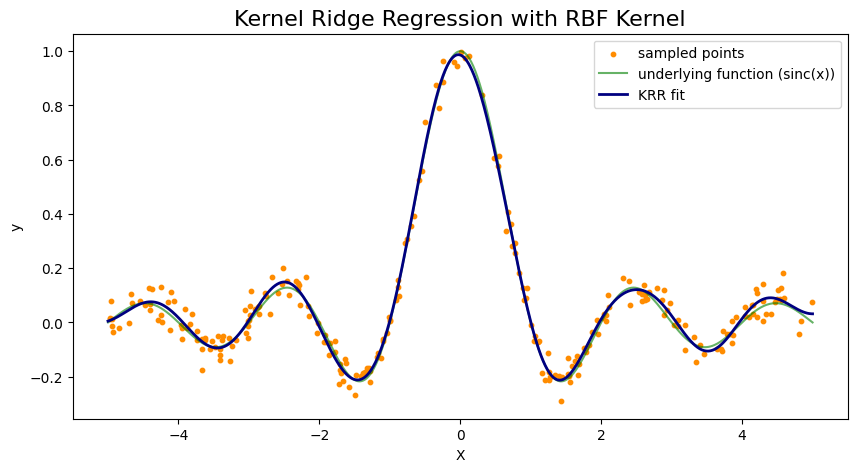

In [17]:
class KernelRidgeRegression:
    def __init__(self, _lambda=1.0, lengthscale=0.1, kernel=None, dtype=torch.float32):
        self._lambda = _lambda
        self.kernel = kernel(nu=1.5, lengthscale=lengthscale)
        self.dtype = dtype

    def fit(self, X, y):
        self.X_train = X.to(self.dtype)
        y = y.to(self.dtype)
        K = self.kernel(X, X).to(self.dtype)
        n = K.shape[0]
        self.alpha_vector = torch.linalg.solve(K + self._lambda * n * torch.eye(n, dtype=self.dtype), y)

    def predict(self, X):
        K = self.kernel(X.to(self.dtype), self.X_train).to(self.dtype)
        return torch.matmul(K, self.alpha_vector)

krr = KernelRidgeRegression(_lambda=_lambda, lengthscale=lengthscale, kernel=RBFKernel, dtype=global_dtype)
krr.fit(train_data, train_labels)
Krr_preds = krr.predict(test_data)
Krr_preds = Krr_preds.detach().numpy()

plt.figure(figsize=(10, 5))
plt.scatter(train_data.numpy(), train_labels.numpy(), color='darkorange', s=10, label='sampled points')
plt.plot(test_data.numpy(), test_labels.numpy(), color='green', alpha=0.6, label='underlying function (sinc(x))')
plt.plot(test_data.numpy(), Krr_preds, color='navy', lw=2, label='KRR fit')
plt.xlabel('X')
plt.ylabel('y')
plt.title(r'Kernel Ridge Regression with RBF Kernel', fontsize=16)
plt.legend()
plt.show()


### 4. Time Complexity

---
What is the operational complexity of running Kernel Ridge Regression?  Here \( Y \) represents the number of test points used during inference. 
<center>

### Time Complexity of Kernel Ridge Regression (KRR)

| **Step**       | **Operation**                                          | **Complexity**          |
|-----------------|--------------------------------------------------------|-------------------------|
| **Fitting**     | Kernel Matrix Computation                             | $\mathcal{O}(n^2)$      |
|                 | Matrix Inversion (Cholesky Decomposition or similar)  | $\mathcal{O}(n^3)$      |
| **Inference**   | Kernel Computation for Predictions                    | $\mathcal{O}(nY)$      |
|                 | Prediction Computation                                 | $\mathcal{O}(nY)$      |

</center>

**Summary**:  
- **Fitting**: Dominated by $\mathcal{O}(n^3)$ due to matrix inversion.  
- **Inference**: $\mathcal{O}(nY)$ for both kernel computation and prediction.

The time complexity of Kernel Ridge Regression and Gaussian Process Regression show multiple similarities, particularly in the fitting phase. Both methods require the inversion of an $n \times n$ matrix, leading to a cubic time complexity $\mathcal{O}(n^3)$. This is not coincidental, and a large quantity of work has gone in to demonstrating that not only are these two methods operationally bouonded by the same subroutine but that mathemtically they are equivilant under certain noise contraints.CITE 